In [1]:
import json
import os
from pathlib import Path
from PIL import Image, ImageOps
import re
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the SDK
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, view_points

# Set user_path_prefix variable. This variable must be set in order to make all filepaths relative!

In [ ]:
user_path_prefix = r"S:\MADS\Capstone"

In [2]:
data_path = os.path.join(user_path_prefix, r"3d-object-detection-for-autonomous-vehicles\Train")
json_path = os.path.join(user_path_prefix, "3d-object-detection-for-autonomous-vehicles\Train\data")
lyftdata = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 8.7 seconds.
Reverse indexing ...
Done reverse indexing in 2.6 seconds.


### Because Lyft does not provide ground truth lables for their testing data in their Kaggle competition, we are going to treat the Validation data (taken from the training images and bounding boxes) as our testing data to perform inference on. We randomly split our training and validation data by the date they were recorded. This ensures we control for seasonality of the data and at a minimum ensures that we don't have imagery captures from the same route on the same day.

# Split our data into Train and Validation sets. Split on date value. Set split to roughly 80/20.

### Define Utility functions to help us get our bounding boxes and corresponding images for our train set and validation set.

#### train_val_split

In [22]:
def train_val_split(lyft_logs):
    unique_dates = sorted(list({d["date_captured"] for d in lyft_logs}))

    #Put 1 in every 5 dates in validation set. This should result in 1/5th of the dates in validation and 4/5th in train.
    train_dates = sorted([unique_dates[i] for i in range(len(unique_dates)) if i % 5 != 0])
    validation_dates = sorted([unique_dates[i] for i in range(len(unique_dates)) if i % 5 == 0])

    train_logs_tokens = list({d["token"] for d in lyftdata.log if d["date_captured"] in train_dates})
    validation_logs_tokens = list({d["token"] for d in lyftdata.log if d["date_captured"] in validation_dates})

    return {"train_logs_tokens": train_logs_tokens, "validation_logs_tokens": validation_logs_tokens}

#### image_category_train_val_split

In [28]:
#In order to find the image files that contain our pedestrian_anns, we must do the following:
#Accumulate the superset of Samples that contain all of our pedestrian_annotations
def image_category_train_val_split(category_name, lyft_dataset_object, category_enumeration = None, box_size_threshold = 5000, positive_category = None, image_box_lookup = None, box_visibility = BoxVisibility.ALL):
    """
    There wasn't a super clean way in the API to select image files that contain annotations from x class. I adapted the method they use in their .render_annotation() method.
    This function is designed to run on a particular category/class. If you want to perform this function for multiple categories, you must supply each category to this function iteratively.

    Args:
    image_box_lookup: While we are iterating over the file path of an image and it's corresponding bounding box coordinates (found in the sample_data table), 
        write these out to a dictionary to use later for IoU object detection comparison. The argument specified should be a path specifying the file location to write this dictionary to. 

    Returns two lists: The first is a list of tuples of (file_path, Box object, camera_intrinsic, sample_token, cam) with respect to the training data. The second is a list of the same tuple structure wrt validation data.
    """

    if image_box_lookup:
        img_bx_lookup = {}

    #If no category_enumeration is provided, use the default. Notice: This filters out the 'car' category to avoid class imbalance.
    if category_enumeration is None:
        category_enumeration = {'pedestrian': 1,
        'animal': 2,
        'other_vehicle': 3,
        'bus': 4,
        'motorcycle': 5,
        'truck': 6,
        'emergency_vehicle': 7,
        'bicycle': 8}

    train_val_images_boxes = []
    # Split our images into train and validation sets. 
    # We don't actually write them to different directories, but rather make different dictionary lookups "image_box_lookup" that the model uses to select data for test/validation.
    train_validation_log_tokens = train_val_split(lyft_dataset_object.log)

    for train_val_key, split_data in train_validation_log_tokens.items():

        scenes_tokens = list({d["token"] for d in lyft_dataset_object.scene if d["log_token"] in split_data})
        sample_tokens = list({d["token"] for d in lyft_dataset_object.sample if d["scene_token"] in scenes_tokens})

        
        annotations = lyft_dataset_object.sample_annotation
        #Filter all annotations down to only annotations our our category of interest.
        category_anns = [d for d in annotations if d["category_name"] == category_name]
        #Filter further to only annotations who belong to our set.
        split_anns = [d for d in category_anns if d["sample_token"] in sample_tokens]

        sample_category_tokens = set()
        for ann in split_anns:
            sample_category_tokens.add(ann["sample_token"])

        category_images_boxes = []
        for sample_token in sample_category_tokens:
            sample_record = lyft_dataset_object.get("sample", sample_token)
            sample_anns = sample_record["anns"]
            cams = [key for key in sample_record["data"].keys() if "CAM" in key]
            
            #We unfortunately do have to iterate through each annotation that exists within the sample_record. There typically aren't more than 20-30 or so.
            #This is because we are in search of the corresponding filepath (and image name) and these must be fetched through .get_sample_data() with the ann supplied as an argument.
            for ann in sample_anns:
                # Figure out which camera the object is fully visible in (this may return nothing)
                for cam in cams:
                    path, box, camera_intrinsic = lyft_dataset_object.get_sample_data(sample_record["data"][cam], box_vis_level=box_visibility, selected_anntokens=[ann])
                    if box:
                        if box[0].name == category_name:
                            #Get the 2D coordinates of our bounding box. This applies the 'camera_intrinsic' matrix via 'view_points' which transforms the box coords from global space to image space.
                            box_coords_all = view_points(box[0].corners(), view = camera_intrinsic, normalize=True)[:2, :]
                            # Calculate bounding box coordinates
                            x_min = np.min(box_coords_all[0])
                            y_min = np.min(box_coords_all[1])
                            x_max = np.max(box_coords_all[0])
                            y_max = np.max(box_coords_all[1])
                            box_coords = [x_min, y_min, x_max, y_max]
                            # Calculate the area of the bounding box
                            box_area = (x_max - x_min) * (y_max - y_min)

                            category_images_boxes.append((str(path), box_coords, camera_intrinsic, sample_token, cam, ann))

                            # Get our label which we want to add to img_bx_lookup so we can pass box coords and corresponding labels to our object detection model.
                            if image_box_lookup and box_area >= box_size_threshold:                                
                                # For binary model where positive categories == 1 and all other categories == 0. 
                                if positive_category:
                                    #Get the 0 index so our label variable is not nested.
                                    label = [1 if category_name == positive_category else 0][0]
                                # Otherwise, standard category input corresponding to one of the input categories in category_enumeration.
                                else:
                                    #Get the 0 index so our label variable is not nested.
                                    label = category_enumeration[category_name][0]
                                
                                #Get the name of the image file itself from the full path.
                                match = re.search(r'images\\(.+)', str(path))
                                if match:
                                    file_name = match.group(1)
                                if file_name in img_bx_lookup:
                                    # If the file_name already exists in the dictionary
                                    img_bx_lookup[file_name]["boxes"].append(box_coords)
                                    img_bx_lookup[file_name]["labels"].append(label)
                                else:
                                    # If the file_name does not exist in the dictionary, create a new entry
                                    # We are not populating predictions here, but they will be used later by the model.
                                    img_bx_lookup[file_name] = {"boxes": [box_coords], "labels": [label], "predicted_boxes": [], "predicted_labels": []}

        train_val_images_boxes.append(category_images_boxes)
        
        # Write our image_box_lookup dict to disk.
        if image_box_lookup:
            out_path = os.path.join(image_box_lookup, train_val_key + f"_{category_name}.json")
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            # Write to a JSON file
            with open(out_path, 'w') as file:
                json.dump(img_bx_lookup, file)
        
    return train_val_images_boxes
    

In [29]:
categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
image_box_lookup = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup_original"
for cat in categories:

    #We can skip car because we know we aren't doing this one, plus its by far the largest and most timely. Further, it would create a class imbalance.
    if cat != "car":
        #Obtain all of the annotations and their corresponding data via image_class_selector
        cat_train_val_images_boxes = image_category_train_val_split(cat, lyftdata, box_size_threshold=5000, positive_category="pedestrian", image_box_lookup=image_box_lookup)

#### merge_img_bx_lookup

In [61]:
def merge_img_bx_lookup(base_path, file_prefix, merged_filename):
    merged_dict = {}
    json_files = [f for f in os.listdir(base_path) if f.startswith(file_prefix) and f.endswith('.json')]

    for file_name in json_files:
        full_path = os.path.join(base_path, file_name)
        with open(full_path, "r") as f:
            file_data = json.load(f)

            for key, value in file_data.items():
                if key not in merged_dict:
                    # If the key is not present, add it with its value
                    merged_dict[key] = value
                else:
                    # If the key is present, extend the boxes and labels
                    merged_dict[key]['boxes'].extend(value['boxes'])
                    merged_dict[key]['labels'].extend(value['labels'])
                    merged_dict[key]['predicted_boxes'].extend(value.get('predicted_boxes', []))
                    merged_dict[key]['predicted_labels'].extend(value.get('predicted_labels', []))

    # Write the merged dictionary to a file
    merged_file_path = os.path.join(base_path, merged_filename)
    with open(merged_file_path, "w") as outfile:
        json.dump(merged_dict, outfile, indent=4)


base_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup_original"
merge_img_bx_lookup(base_path, 'train', 'train_merged.json')
merge_img_bx_lookup(base_path, 'validation', 'validation_merged.json')


# Image Classification

## Preprocess pedestrain images with additional processes like Padding and Center cropping for input into image classification model

#### crop_to_boundingbox

In [6]:
def crop_to_boundingbox(image_category_train_val_split, output_path, box_area_threshold = 5000):
    path, box_coords, camera_intrinsic, sample_token, cam, ann = image_category_train_val_split
    
    # Calculate bounding box coordinates
    x_min = np.min(box_coords[0])
    y_min = np.min(box_coords[1])
    x_max = np.max(box_coords[0])
    y_max = np.max(box_coords[1])

    # Calculate the area of the bounding box
    box_area = (x_max - x_min) * (y_max - y_min)

    if box_area > box_area_threshold:
        image = Image.open(path)
        match = re.search(r'images\\(.+)', path)

        if match:
            file_name = match.group(1)
        else:
            print("Pattern not found in the path", path)
            pass

        # Crop the image. This is our initial cropping from the full size image. It is with respect to the bounding box size using box_area_threshold.
        # Pillow uses a system of (left, upper, right, lower)
        image_cropped = image.crop((x_min, y_min, x_max, y_max))

        # Check if the directory exists, if not, create it
        Path(output_path).mkdir(parents=True, exist_ok=True)
        #Save the image
        image_cropped.save(os.path.join(output_path, "cropped_" + file_name[:-5] + "_" + ann + file_name[-5:]))

In [7]:
# categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
# for cat in categories:

#     #We can skip car because we know we aren't doing this one, plus its by far the largest and most timely.
#     if cat != "car":
#         #Obtain all of the annotations and their corresponding data via image_class_selector
#         cat_train_val_images_boxes = image_category_train_val_split(cat, lyftdata, train_validation_log_tokens= [train_logs_tokens, validation_logs_tokens])

#         cat_train = cat_train_val_images_boxes[0]
#         cat_val = cat_train_val_images_boxes[1]

#         #Do the actual cropping and write cropped images to disk
#         train_image_output_path = os.path.join(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\train_cropped_images", cat +"_cropped")
#         val_image_output_path = os.path.join(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\validation_cropped_images", cat +"_cropped")
        
#         for i in range(len(cat_train)):
#             crop_to_boundingbox(cat_train[i], output_path=train_image_output_path, box_area_threshold=5000)

#         for i in range(len(cat_val)):
#             crop_to_boundingbox(cat_val[i], output_path=val_image_output_path, box_area_threshold=5000)

#### dynamic_transform

In [23]:
def dynamic_transform(cropped_images_dir, image_sizes_list, lyftdata, partial_images = False):
    """
    partial_images: If set to true, create additional 
    """


    for size in image_sizes_list:
        categories = [d["name"] for d in lyftdata.category if d["name"] != "car"]
        for category in categories:
            category_dir = os.path.join(cropped_images_dir, category)
            if partial_images:
                new_out_dir = os.path.join(cropped_images_dir, category + "_" + str(size) + "_partials")
            else:
                new_out_dir = os.path.join(cropped_images_dir, category + "_" + str(size))
                
            if not os.path.exists(new_out_dir):
                os.makedirs(new_out_dir)

            #For each image in the directory "category", modify it such that it is resized to "size".
            for image_file in os.listdir(category_dir):
                image_path = os.path.join(category_dir, image_file)
                image_main = Image.open(image_path)
                image_main_width, image_main_height = image_main.size
                images = [image_main]

                if partial_images:
                    image_left = image_main.crop((0, 0, image_main_width // 2, image_main_height))
                    image_right = image_main.crop((0, 0, image_main_width // 2, image_main_height))
                    images.extend([image_left, image_right])

                for image in images:
                    image_width, image_height = image.size

                    if image_width < size or image_height < size:
                        # Calculate padding
                        padding_left = (size - image_width) // 2 if image_width < size else 0
                        padding_top = (size - image_height) // 2 if image_height < size else 0

                        # Adjust for odd total padding
                        padding_right = size - image_width - padding_left
                        padding_bottom = size - image_height - padding_top

                        # Apply padding
                        image = ImageOps.expand(image, (padding_left, padding_top, padding_right, padding_bottom), fill=0)

                    elif image_width > size or image_height > size:
                        # Crop the image to the required size if it's larger
                        image = transforms.CenterCrop(size)(image)

                    # No else case needed, as no action is taken if the image is already the required size
                    if image.size != (size, size):
                        # Raise an exception
                        raise RuntimeError(f"Image size after transformation does not match required size of {size} for image and instead is of size {image.size}: {image_path}. Original image size: {image_width} {image_height}")
                    
                    # Save the transformed image
                    image.save(os.path.join(new_out_dir, image_file))

## Only run the code in the cell below if we haven't yet preprocessed any images or if we need to process them at a new, different size.

In [25]:
# cropped_images_dir = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\train_cropped_images"
# sizes = [224]
# dynamic_transform(cropped_images_dir, sizes, lyftdata, partial_images=True)

# print("transforms_with_partials done.")

# dynamic_transform(cropped_images_dir, sizes, lyftdata, partial_images=False)

## Read in our image_box_lookup JSON tables that were produced in 'image_category_train_val_split'

In [4]:
train_merged_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup_original\train_merged.json"
train_pedestrians_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup_original\train_logs_tokens_pedestrian.json"
validation_merged_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup_original\validation_merged.json"
validation_pedestrians_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup_original\validation_logs_tokens_pedestrian.json"
# predictions_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\validation_merged_w_predictions.json"
# merge_dictionaries(image_box_lookup_validation, validation_merged)

In [5]:
base_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup_original"
img_bx_dir = os.listdir(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\images_original\img_bx_lookup_original")
img_bx_reference = {}
for f in img_bx_dir:
    file_path = os.path.join(base_path, f)
    with open(file_path, "r") as file:
        d = json.load(file)
        img_bx_reference[f] = d
        
img_bx_reference.keys()


dict_keys(['train_logs_tokens_animal.json', 'train_logs_tokens_bicycle.json', 'train_logs_tokens_bus.json', 'train_logs_tokens_emergency_vehicle.json', 'train_logs_tokens_motorcycle.json', 'train_logs_tokens_other_vehicle.json', 'train_logs_tokens_pedestrian.json', 'train_logs_tokens_truck.json', 'train_merged.json', 'validation_logs_tokens_animal.json', 'validation_logs_tokens_bicycle.json', 'validation_logs_tokens_bus.json', 'validation_logs_tokens_emergency_vehicle.json', 'validation_logs_tokens_motorcycle.json', 'validation_logs_tokens_other_vehicle.json', 'validation_logs_tokens_pedestrian.json', 'validation_logs_tokens_truck.json', 'validation_merged.json'])

In [6]:
train_merged = img_bx_reference["train_merged.json"]
validation_merged = img_bx_reference["validation_merged.json"]
print(len(train_merged))
print(len(validation_merged))
# print(len(predictions_file))

28600
35226


In [7]:
train_merged

{'host-a004_cam0_1232817652451064006.jpeg': {'boxes': [[963.2922978186496,
    676.5313843966901,
    1136.0242514354854,
    776.4546413663261],
   [722.7988805255987, 496.614778432843, 849.0012625293366, 604.402950528869],
   [777.6164623794784, 515.205862285076, 859.8336773765589, 664.184520253418]],
  'labels': [0, 0, 1],
  'predicted_boxes': [],
  'predicted_labels': []},
 'host-a004_cam1_1232825406034300006.jpeg': {'boxes': [[778.3852680775809,
    595.9302035859927,
    917.8241409497175,
    702.3081788250164],
   [712.9104757521599,
    484.99403387552985,
    795.4703181122396,
    665.6161815453116]],
  'labels': [0, 1],
  'predicted_boxes': [],
  'predicted_labels': []},
 'host-a004_cam2_1232825406217652006.jpeg': {'boxes': [[73.2050130243984,
    604.6926990308148,
    241.02897703741132,
    734.3556087123955]],
  'labels': [0],
  'predicted_boxes': [],
  'predicted_labels': []},
 'host-a004_cam1_1232825405834300006.jpeg': {'boxes': [[495.98203744391367,
    592.904611805

In [8]:

validation_positive_images = []
for k, v in validation_merged.items():
    labels = v["labels"]
    if any(labels):
        validation_positive_images.append(k)

print(len(validation_positive_images))

train_positive_images = []
for k, v in train_merged.items():
    labels = v["labels"]
    if any(labels):
        train_positive_images.append(k)

print(len(train_positive_images))

6219
5367


In [6]:
predictions_dict = {}
for k,v in predictions_file.items():
    sub_keys = v.keys()
    for key in sub_keys:
        if key.startswith("predict"):
            predictions_dict[k] = v

predictions_dict

{'host-a011_cam1_1233087927034517006.jpeg': {'boxes': [[1014.4382388357262,
    524.3999840944039,
    1103.960366248311,
    613.7511238677879],
   [310.78824910098274,
    507.31547959989643,
    409.7141034337978,
    671.1648263972268],
   [533.3112744753846,
    508.31743102793945,
    647.0238990059231,
    681.6000893237831],
   [566.4015113703897,
    478.06808541189764,
    706.4169936545019,
    574.9046049668391],
   [777.4317647510476,
    470.2958360492121,
    864.6014261650806,
    546.8225612363699]],
  'labels': [0, 1, 1, 0, 0],
  'predicted_boxes': [[883.03759765625,
    799.9520263671875,
    883.783447265625,
    799.99951171875]],
  'predicted_labels': [[883.03759765625,
    799.9520263671875,
    883.783447265625,
    799.99951171875]]},
 'host-a004_cam0_1232905220351064006.jpeg': {'boxes': [[23.081734433559465,
    518.1214608667683,
    168.58950851537728,
    592.2879465366981],
   [1048.1397126216098,
    516.815730167131,
    1127.7618601892214,
    614.10977

In [9]:
def display_sample_boxes(main_images_path, data_dict_single):
    image_name = list(data_dict_single.keys())[0]
    image_path = os.path.join(main_images_path, image_name)
    image = Image.open(image_path)
    gt_boxes = data_dict_single[image_name]["boxes"]
    gt_labels = data_dict_single[image_name]["labels"]
    predicted_boxes = data_dict_single[image_name]["predicted_boxes"]
    predicted_labels = data_dict_single[image_name]["predicted_labels"]

    # Create a matplotlib figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch for the bounding box
    for i in range(len(gt_boxes)):
        x_min = gt_boxes[i][0]
        y_min = gt_boxes[i][1]
        x_max = gt_boxes[i][2]
        y_max = gt_boxes[i][3]
        label = gt_labels[i]
        color = ["b" if label == 1 else "r"][0]

        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor=color, facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)

    for i in range(len(predicted_boxes)):
        x_min = predicted_boxes[i][0]
        y_min = predicted_boxes[i][1]
        x_max = predicted_boxes[i][2]
        y_max = predicted_boxes[i][3]
        # label = predicted_labels[i]
        # color = ["b" if label == 1 else "r"][0]

        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor="g", facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)

    # Display the plot
    plt.show()



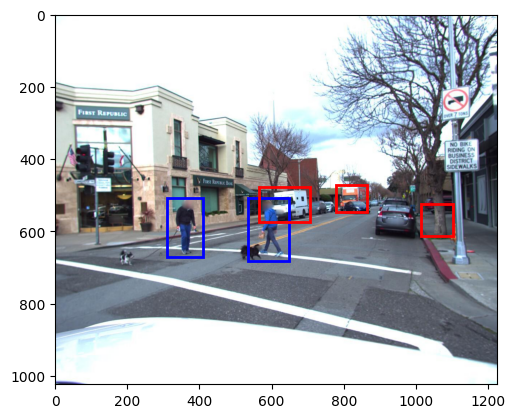

In [18]:
main_images_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images"
test_image = 'host-a011_cam1_1233087927034517006.jpeg'
data_dict_single = {k:v for k,v in predictions_dict.items() if k == test_image}
display_sample_boxes(main_images_path=main_images_path, data_dict_single=data_dict_single)

[[436.58900588082435, 182.933567506881, 543.9050843147419, 283.7986922012577]] [[436.58900588082435, 482.933567506881, 543.9050843147419, 583.7986922012577]]


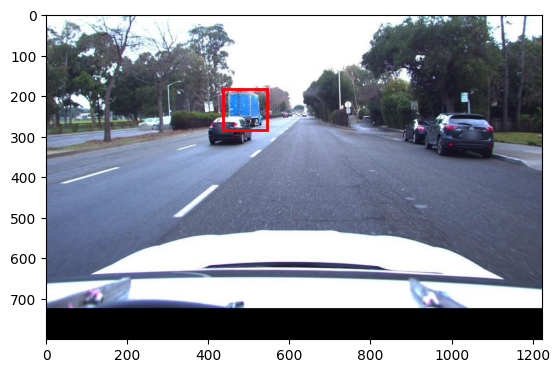

In [15]:
# Load the image
main_images_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection"
image_name = "host-a004_cam0_1232815269651064006.jpeg"
image_path = os.path.join(main_images_path, image_name)
image = Image.open(image_path)
with open(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection\img_bx_lookup\train_merged.json") as f:
    cropped_training_merged = json.load(f)
with open(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection\img_bx_lookup\validation_merged.json") as f:
    cropped_validation_merged = json.load(f)
boxes_altered = cropped_validation_merged[image_name]["boxes"]
labels = cropped_validation_merged[image_name]["labels"]
boxes = validation_merged[image_name]["boxes"]
print(boxes_altered, boxes)


# Create a matplotlib figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Create a Rectangle patch for the bounding box
for i in range(len(boxes)):
    x_min = boxes_altered[i][0]
    y_min = boxes_altered[i][1]
    x_max = boxes_altered[i][2]
    y_max = boxes_altered[i][3]
    label = labels[i]
    color = ["b" if label == 1 else "r"][0]

    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor=color, facecolor='none')
    # Add the rectangle to the plot
    ax.add_patch(rect)

# Display the plot
plt.show()

In [2]:
# def resize_and_overwrite_images_in_directory(directory, max_width, max_height, outdirectory):
#     image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
#     total_images = len(image_files)
#     processed_images = 0

#     for filename in image_files:
#         filepath = os.path.join(directory, filename)
#         with Image.open(filepath) as img:
#             width, height = img.size

#             # Crop if larger
#             if width > max_width or height > max_height:
#                 new_width = min(width, max_width)
#                 new_height = min(height, max_height)
#                 left = (width - new_width) / 2
#                 top = (height - new_height) / 2
#                 right = (width + new_width) / 2
#                 bottom = (height + new_height) / 2
#                 img = img.crop((left, top, right, bottom))

#             # Pad if smaller
#             if img.size[0] < max_width or img.size[1] < max_height:
#                 padding_left = (max_width - img.size[0]) // 2
#                 padding_top = (max_height - img.size[1]) // 2
#                 padding_right = max_width - img.size[0] - padding_left
#                 padding_bottom = max_height - img.size[1] - padding_top
#                 img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom))

#             out_path = os.path.join(outdirectory, filename)
#             img.save(out_path)

#         processed_images += 1
#         if processed_images % (total_images // 10) == 0 or processed_images == total_images:
#             print(f"Processed {processed_images / total_images * 100:.0f}% of images")

#     print("Processing complete.")


# directory_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images'
# out_directory_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\resize_1024_1224"
# resize_and_overwrite_images_in_directory(directory_path, outdirectory=out_directory_path, max_width=1224, max_height=1024)


Processed 10% of images
Processed 20% of images
Processed 30% of images
Processed 40% of images
Processed 50% of images
Processed 60% of images
Processed 70% of images
Processed 80% of images
Processed 90% of images
Processed 100% of images
Processed 100% of images
Processing complete.


# Object Detection

## crop_image_extremities

In [11]:
def crop_image_extremities(image_directory, outdirectory, image_box_lookup_paths, height_range=None, width_range=None):
    """
    image_box_lookup_paths: give a list of two paths where the first path is to the training image_box_lookup and the second is valdiation.
    """
    with open(image_box_lookup_paths[0]) as f:
        image_box_lookup_training = json.load(f)
    with open(image_box_lookup_paths[1]) as f:
        image_box_lookup_validation = json.load(f)
    
    images_subset = set(list(image_box_lookup_training.keys()) + list(image_box_lookup_validation.keys()))
    known_sizes = [(2048, 864), (1224, 1024), (1920, 1080)]

    # all_image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]

    total_images = len(images_subset)
    processed_images = 0

    #Instead of performing croping for all 150k images, we only crop the images we know we will be feeding into the model as indicated by our image_subset. This saves ample time.
    for filename in images_subset:
        filepath = os.path.join(image_directory, filename)
        with Image.open(filepath) as img:
            width, height = img.size
            
            # We only crop the top of these images
            if img.size == known_sizes[0]:
                crop_height_top_only = height_range[0]  # Adjust this value as needed
                img_cropped = img.crop((0, crop_height_top_only, width, height))
                out_path = os.path.join(outdirectory, filename)
                img_cropped.save(out_path)

                # If this is an image that corresponds to our given image_box_lookup, this means we have this image and its original bounding box coords as a refernce for model input.
                # When we crop an image, the new location for 0 in the respective axis changes. Thus, if we don't perform the same change in our bounding box coords, they will shift and be incorrect.
                if filename in image_box_lookup_training.keys() or filename in image_box_lookup_validation.keys():
                    boxes = image_box_lookup_training.get(filename, {}).get("boxes", []) or \
                            image_box_lookup_validation.get(filename, {}).get("boxes", [])
                    updated_boxes = []
                    for box_coords in boxes:
                        x1, y1, x2, y2 = box_coords
                        y1_new = max(y1-height_range[0], 0)
                        y2_new = max(y2-height_range[0], 0)
                        updated_boxes.append([x1, y1_new, x2, y2_new])
                    # Update the box coordinates in the lookup
                    if filename in image_box_lookup_training:
                        image_box_lookup_training[filename]["boxes"] = updated_boxes
                    elif filename in image_box_lookup_validation:
                        image_box_lookup_validation[filename]["boxes"] = updated_boxes


            # Crop both the top and bottom of these images
            else:
                left = width_range[0] if width_range else 0
                upper = height_range[0] if height_range else 0
                right = width_range[1] if width_range else width
                lower = height_range[1] if height_range else height

                img_cropped = img.crop((left, upper, right, lower))
                out_path = os.path.join(outdirectory, filename)
                img_cropped.save(out_path)

                # If this is an image that corresponds to our given image_box_lookup, this means we have this image and its original bounding box coords as a refernce for model input.
                # When we crop an image, the new location for 0 in the respective axis changes. Thus, if we don't perform the same change in our bounding box coords, they will shift and be incorrect.
                if filename in image_box_lookup_training.keys() or filename in image_box_lookup_validation.keys():
                    boxes = image_box_lookup_training.get(filename, {}).get("boxes", []) or \
                            image_box_lookup_validation.get(filename, {}).get("boxes", [])
                    updated_boxes = []
                    for box_coords in boxes:
                        x1, y1, x2, y2 = box_coords
                        y1_new = max(y1 - height_range[0], 0)
                        y2_new = min(y2 - height_range[0], height_range[1] - height_range[0])
                        updated_boxes.append([x1, y1_new, x2, y2_new])
                    # Update the box coordinates in the lookup
                    if filename in image_box_lookup_training:
                        image_box_lookup_training[filename]["boxes"] = updated_boxes
                    elif filename in image_box_lookup_validation:
                        image_box_lookup_validation[filename]["boxes"] = updated_boxes

        processed_images += 1
        if processed_images % (total_images // 10) == 0 or processed_images == total_images:
            print(f"Processed {processed_images / total_images * 100:.0f}% of images")

        with open(os.path.join(outdirectory, "img_bx_lookup", "train_merged.json"), "w") as f:
            json.dump(image_box_lookup_training, f)
        with open(os.path.join(outdirectory, "img_bx_lookup", "validation_merged.json"), "w") as f:
            json.dump(image_box_lookup_training, f)

    print("Processing complete.")

# Example usage
directory_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images'
out_directory_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection"
image_box_lookup_paths =[r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection\img_bx_lookup\train_merged.json",
                         r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection\img_bx_lookup\validation_merged.json"]
crop_image_extremities(directory_path, outdirectory=out_directory_path, image_box_lookup_paths=image_box_lookup_paths, height_range=(300, 1100), width_range=None)


Processed 10% of images
Processed 20% of images
Processed 30% of images
Processed 40% of images
Processed 50% of images
Processed 60% of images
Processed 70% of images
Processed 80% of images
Processed 90% of images
Processed 100% of images
Processed 100% of images
Processing complete.


In [71]:
def find_unique_img_sizes(img_dir):
    unique_sizes = {}
    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    
    for filename in image_files:
        filepath = os.path.join(img_dir, filename)
        with Image.open(filepath) as img:
            width, height = img.size
            size_tuple = (width, height)

            if size_tuple not in unique_sizes:
                unique_sizes[size_tuple] = {"images": [], "count": 0}

            unique_sizes[size_tuple]["images"].append(filename)
            unique_sizes[size_tuple]["count"] += 1

    return unique_sizes

image_size_unique = find_unique_img_sizes(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images")

for size, data in image_size_unique.items():
    # print(f"Size: {size}, Count: {data['count']}, Images: {data['images']}")
    print(f"Size: {size}, Count: {data['count']}")


Size: (1224, 1024), Count: 111888
Size: (2048, 864), Count: 18648
Size: (1920, 1080), Count: 28221


In [11]:
# wideeye_lens = set(image_size_unique[(2048, 864)]["images"])
# print(len(wideeye_lens))
# wideeye_lens

test_set = set(os.listdir(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Object_Detection"))
test_set

{'host-a004_cam0_1232815252251064006.jpeg',
 'host-a004_cam0_1232815252451064006.jpeg',
 'host-a004_cam0_1232815252651064006.jpeg',
 'host-a004_cam0_1232815252851064006.jpeg',
 'host-a004_cam0_1232815253051064006.jpeg',
 'host-a004_cam0_1232815253251064006.jpeg',
 'host-a004_cam0_1232815253451064006.jpeg',
 'host-a004_cam0_1232815253651064006.jpeg',
 'host-a004_cam0_1232815253851064006.jpeg',
 'host-a004_cam0_1232815254051064006.jpeg',
 'host-a004_cam0_1232815254251064006.jpeg',
 'host-a004_cam0_1232815254451064006.jpeg',
 'host-a004_cam0_1232815254651064006.jpeg',
 'host-a004_cam0_1232815254851064006.jpeg',
 'host-a004_cam0_1232815255051064006.jpeg',
 'host-a004_cam0_1232815255251064006.jpeg',
 'host-a004_cam0_1232815255451064006.jpeg',
 'host-a004_cam0_1232815255651064006.jpeg',
 'host-a004_cam0_1232815255851064006.jpeg',
 'host-a004_cam0_1232815256051064006.jpeg',
 'host-a004_cam0_1232815256251064006.jpeg',
 'host-a004_cam0_1232815256451064006.jpeg',
 'host-a004_cam0_123281525665106

In [12]:
working_images = set(list(train_merged.keys()) + list(validation_merged.keys()))
working_images


{'host-a011_cam5_1234639314267719006.jpeg',
 'host-a102_cam0_1242755407349319006.jpeg',
 'host-a015_cam3_1233957279200936006.jpeg',
 'host-a008_cam2_1236016347217906006.jpeg',
 'host-a007_cam6_1233529712750905006.jpeg',
 'host-a004_cam1_1232817652834300006.jpeg',
 'host-a011_cam0_1233087935651142006.jpeg',
 'host-a011_cam3_1232841347600995006.jpeg',
 'host-a011_cam3_1235933793100995006.jpeg',
 'host-a102_cam4_1242755404516216006.jpeg',
 'host-a011_cam0_1233964378751142006.jpeg',
 'host-a004_cam4_1233693192584193006.jpeg',
 'host-a015_cam1_1236112601334306006.jpeg',
 'host-a011_cam3_1233964380300995006.jpeg',
 'host-a101_cam6_1242749259944000006.jpeg',
 'host-a101_cam4_1242749267915816006.jpeg',
 'host-a101_cam5_1241462213733330006.jpeg',
 'host-a004_cam6_1233683004450948006.jpeg',
 'host-a011_cam2_1236123641517605006.jpeg',
 'host-a009_cam4_1236118570384385006.jpeg',
 'host-a009_cam3_1236118475700965006.jpeg',
 'host-a011_cam4_1232485960984485006.jpeg',
 'host-a004_cam6_123395573665094

In [13]:
# Find common elements
common_elements = test_set.intersection(working_images)

# Convert to list
common_list = list(common_elements)

print(common_list)

['host-a004_cam0_1232815269651064006.jpeg', 'host-a004_cam0_1232815260051064006.jpeg', 'host-a004_cam0_1232815270051064006.jpeg', 'host-a004_cam0_1232815253451064006.jpeg', 'host-a004_cam0_1232815267651064006.jpeg', 'host-a004_cam0_1232815258251064006.jpeg', 'host-a004_cam0_1232815268251064006.jpeg', 'host-a004_cam0_1232815252651064006.jpeg', 'host-a004_cam0_1232815257251064006.jpeg', 'host-a004_cam0_1232815253051064006.jpeg', 'host-a004_cam0_1232815256451064006.jpeg', 'host-a004_cam0_1232815257451064006.jpeg', 'host-a004_cam0_1232815264451064006.jpeg', 'host-a004_cam0_1232815268451064006.jpeg', 'host-a004_cam0_1232815264251064006.jpeg', 'host-a004_cam0_1232815256651064006.jpeg', 'host-a004_cam0_1232815269251064006.jpeg', 'host-a004_cam0_1232815258651064006.jpeg', 'host-a004_cam0_1232815257651064006.jpeg', 'host-a004_cam0_1232815263051064006.jpeg', 'host-a004_cam0_1232815254051064006.jpeg', 'host-a004_cam0_1232815259851064006.jpeg', 'host-a004_cam0_1232815266651064006.jpeg', 'host-a004

# Data Exploration

In [4]:
annos_class = lyftdata.sample_annotation
categories = [d["name"] for d in lyftdata.category if d["name"] != "car"]
#Filter all annotations down to only annotations our our class of interest.
# class_anns = [d for d in annos_class if d["category_name"] == class_name]
categories

['pedestrian',
 'animal',
 'other_vehicle',
 'bus',
 'motorcycle',
 'truck',
 'emergency_vehicle',
 'bicycle']

In [9]:
category_distribution = {}
for cat in categories:
    category_distribution[cat] = 0

for d in lyftdata.sample_annotation:
    if d["category_name"] != "car":
        category_distribution[d["category_name"]] +=1

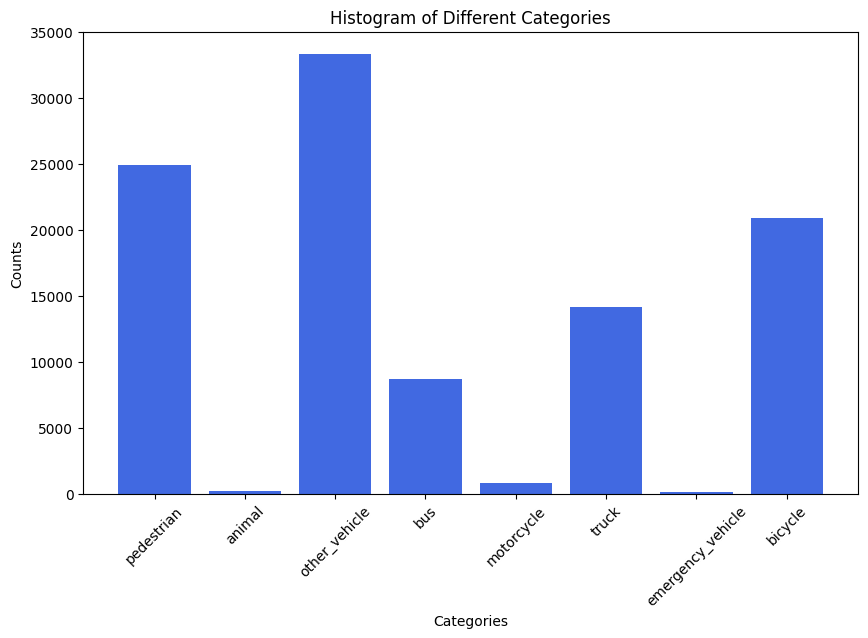

In [15]:
# Extracting keys and values
categories = list(category_distribution.keys())
counts = list(category_distribution.values())

# Creating the histogram
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='royalblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Histogram of Different Categories')
plt.xticks(rotation=45)  # Rotate category labels for better readability

# Show the plot
histo_outpath = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\Image_Classification\train_cropped_images\Report_examples\category_distribution.png"
plt.savefig(histo_outpath, bbox_inches='tight')
plt.show()